In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
'''
import os
os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder
'''

"\nimport os\nos.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder\n"

# Requirements

In [3]:
'''
#This commented section is required to run the creation of MNIST-1D dataset
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
'''

import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from scipy.ndimage.interpolation import zoom
import skimage.io 
import skimage.segmentation
import copy
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from random import randrange
import seaborn as sns
import tensorflow 
import keras
from keras.applications.imagenet_utils import decode_predictions
import tensorflow.keras 
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import * 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

In [4]:
'''
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset
'''

"\n#@title MNIST-1D utils\n\n# transformations of the templates which will make them harder to classify\ndef pad(x, padding):\n    low, high = padding\n    p = low + int(np.random.rand()*(high-low+1))\n    return np.concatenate([x, np.zeros((p))])\n\ndef shear(x, scale=10):\n    coeff = scale*(np.random.rand() - 0.5)\n    return x - coeff*np.linspace(-0.5,.5,len(x))\n\ndef translate(x, max_translation):\n    k = np.random.choice(max_translation)\n    return np.concatenate([x[-k:], x[:-k]])\n\ndef corr_noise_like(x, scale):\n    noise = scale * np.random.randn(*x.shape)\n    return gaussian_filter(noise, 2)\n\ndef iid_noise_like(x, scale):\n    noise = scale * np.random.randn(*x.shape)\n    return noise\n\ndef interpolate(x, N):\n    scale = np.linspace(0,1,len(x))\n    new_scale = np.linspace(0,1,N)\n    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)\n    return new_x\n\ndef transform(x, y, args, eps=1e-8):\n    new_x = pad(x+eps, args.padding) # pad\n    new_x = interpol

In [5]:
#from mnist1d_utils import *

# Dataset

In [6]:
#dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

In [7]:
'''
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))
'''

"\n#@title Show some examples from the MNIST 1-D dataset\n\nplt.figure(figsize=(20,3))\n\nplt.subplot(151)\nplt.plot(dataset['x'][0], 'r')\nplt.axis('off')\nplt.title('predicted class: '+str(dataset['y'][0]))\n\nplt.subplot(152)\nplt.plot(dataset['x'][1], 'r')\nplt.axis('off')\nplt.title('predicted class: '+str(dataset['y'][1]))\n\nplt.subplot(153)\nplt.plot(dataset['x'][2], 'r')\nplt.axis('off')\nplt.title('predicted class: '+str(dataset['y'][2]))\n\nplt.subplot(154)\nplt.plot(dataset['x'][3], 'r')\nplt.axis('off')\nplt.title('predicted class: '+str(dataset['y'][3]))\n\nplt.subplot(155)\nplt.plot(dataset['x'][4], 'r')\nplt.axis('off')\nplt.title('predicted class: '+str(dataset['y'][4]))\n"

In [8]:
#@title Show the digit templates in the MNIST 1-D dataset 
'''
plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')
'''

"\nplt.figure(figsize=(20,8))\n\nplt.subplot(251)\nplt.plot(dataset['templates']['x'][0], 'r')\nplt.axis('off')\nplt.title('predicted class: 0')\n\nplt.subplot(252)\nplt.plot(dataset['templates']['x'][1], 'r')\nplt.axis('off')\nplt.title('predicted class: 1')\n\nplt.subplot(253)\nplt.plot(dataset['templates']['x'][2], 'r')\nplt.axis('off')\nplt.title('predicted class: 2')\n\nplt.subplot(254)\nplt.plot(dataset['templates']['x'][3], 'r')\nplt.axis('off')\nplt.title('predicted class: 3')\n\nplt.subplot(255)\nplt.plot(dataset['templates']['x'][4], 'r')\nplt.axis('off')\nplt.title('predicted class: 4')\n\nplt.subplot(256)\nplt.plot(dataset['templates']['x'][5], 'r')\nplt.axis('off')\nplt.title('predicted class: 5')\n\nplt.subplot(257)\nplt.plot(dataset['templates']['x'][6], 'r')\nplt.axis('off')\nplt.title('predicted class: 6')\n\nplt.subplot(258)\nplt.plot(dataset['templates']['x'][7], 'r')\nplt.axis('off')\nplt.title('predicted class: 7')\n\nplt.subplot(259)\nplt.plot(dataset['templates']

Saving the dataset

In [9]:
'''
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()
'''

'\nf = open("MNIST1D.pkl","wb")\npickle.dump(dataset,f)\nf.close()\n'

#Reading dataset from pickle file



In [10]:
#filepath here would be the path to the pickle file
data = pd.read_pickle('/content/drive/MyDrive/MNIST1D.pkl')

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [11]:
##Task1-Question1

#Your code starts from here 
weight_decay = 5e-4

model = Sequential([Conv1D(filters=25, 
                           kernel_size=5, 
                           strides=1, 
                           padding='same',
                           activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
                    Conv1D(filters=25, 
                           kernel_size=3, 
                           strides=1, 
                           padding='same',
                           activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
                    Conv1D(filters=25, 
                           kernel_size=3, 
                           strides=1, 
                           padding='same',
                           activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)),
                    Flatten(),
                    Dense(units=10, 
                          activation='softmax')])
             

##

# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [12]:
#Preparing Train, Val and Test Data
train_data = data['x'][0:3900]
train_label = data['y'][0:3900] 
train_data_reshaped = np.expand_dims(train_data, axis=-1)

val_data = data['x'][-100:]
val_label = data['y'][-100:]
val_data_reshaped = np.expand_dims(val_data, axis=-1)


test_data = data['x_test']
test_label = data['y_test'] 
test_data_reshaped = np.expand_dims(test_data, axis=-1)

#one hot encoding for class labels
train_label_o = to_categorical(train_label, num_classes=10)
val_label_o = to_categorical(val_label, num_classes=10)
test_label_o = to_categorical(test_label, num_classes=10)

inp = train_data_reshaped[0]
inp_reshaped = np.expand_dims(inp, axis=0)

In [13]:
##Task1-Question2

optimizer = SGD(learning_rate=0.01, name='SGD')
loss = 'categorical_crossentropy'
epochs = 200


model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

history = model.fit(x=train_data_reshaped, 
                    y=train_label_o,  
                    epochs=epochs, 
                    verbose=1,
                    batch_size=32,
                    callbacks=None, 
                    validation_data=(val_data_reshaped, val_label_o))
model.save('/content/mnist1d_model.h5')

##

Epoch 1/200
122/122 [==============================] - 11s 8ms/step - loss: 2.2912 - accuracy: 0.1297 - val_loss: 2.2275 - val_accuracy: 0.1400
Epoch 2/200
122/122 [==============================] - 1s 5ms/step - loss: 2.1582 - accuracy: 0.1864 - val_loss: 2.0150 - val_accuracy: 0.2600
Epoch 3/200
122/122 [==============================] - 1s 5ms/step - loss: 1.9410 - accuracy: 0.2390 - val_loss: 1.8056 - val_accuracy: 0.2500
Epoch 4/200
122/122 [==============================] - 1s 5ms/step - loss: 1.8119 - accuracy: 0.2741 - val_loss: 1.7182 - val_accuracy: 0.2700
Epoch 5/200
122/122 [==============================] - 1s 5ms/step - loss: 1.7515 - accuracy: 0.2979 - val_loss: 1.6516 - val_accuracy: 0.2900
Epoch 6/200
122/122 [==============================] - 1s 5ms/step - loss: 1.6999 - accuracy: 0.3279 - val_loss: 1.6174 - val_accuracy: 0.3200
Epoch 7/200
122/122 [==============================] - 1s 5ms/step - loss: 1.6529 - accuracy: 0.3505 - val_loss: 1.5640 - val_accuracy: 0.320

In [14]:
#model = load_model('/content/drive/MyDrive/mnist1d_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Plotting the training progress

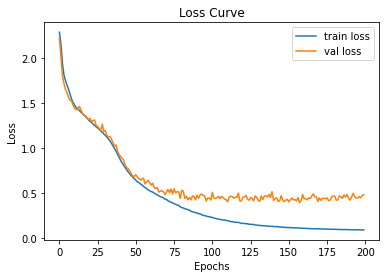

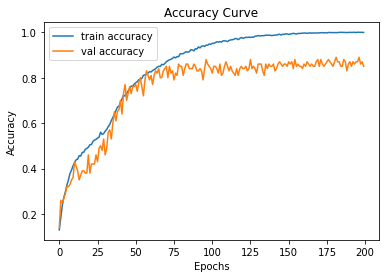

In [15]:
##Task1-Question3.a

#Loss curve

plt.plot(range(epochs), history.history['loss'], label ='train loss')
plt.plot(range(epochs), history.history['val_loss'], label='val loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

#Accuracy Curve

plt.plot(range(epochs), history.history['accuracy'], label ='train accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 
plt.show()
##

In [16]:
##Task1-Question3.b

results = model.evaluate(x=test_data_reshaped, y=test_label_o, batch_size=32)
print("Overall classification accuracy on test set:", results[1])

32/32 [==============================] - 0s 5ms/step - loss: 0.5197 - accuracy: 0.8860
Overall classification accuracy on test set: 0.8859999775886536


In [17]:
##Task1-Question3.c

# Class-wise classification accuracy for all classes
from sklearn.metrics import confusion_matrix

y_pred_o = model.predict(x=test_data_reshaped, batch_size=32)
y_pred = np.argmax(y_pred_o,axis=1)

matrix = confusion_matrix(y_true = test_label, y_pred = y_pred)
classwise_accuracy_array = matrix.diagonal()/matrix.sum(axis=1)

for i in np.unique(train_label):
  print(f'Accuracy for class: {i} is {classwise_accuracy_array[i]}')

Accuracy for class: 0 is 1.0
Accuracy for class: 1 is 0.8365384615384616
Accuracy for class: 2 is 0.8314606741573034
Accuracy for class: 3 is 0.9811320754716981
Accuracy for class: 4 is 0.8490566037735849
Accuracy for class: 5 is 0.8469387755102041
Accuracy for class: 6 is 0.9191919191919192
Accuracy for class: 7 is 0.875
Accuracy for class: 8 is 0.9387755102040817
Accuracy for class: 9 is 0.7745098039215687


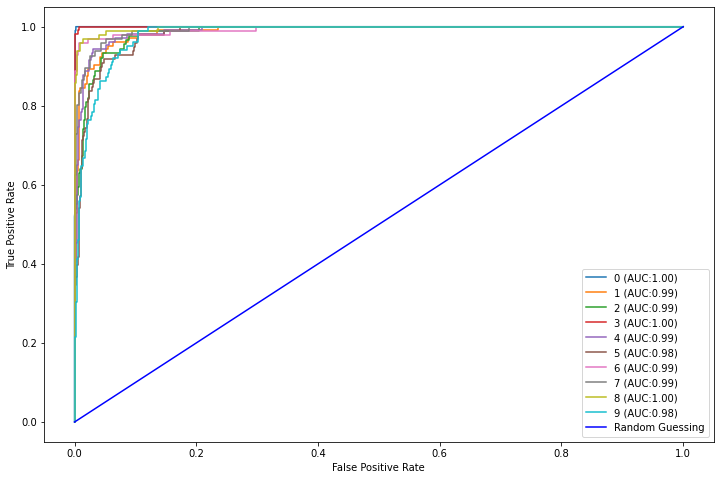

In [19]:
##Task1-Question3.d
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

for (idx, c_label) in enumerate(classes):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_label_o[:,idx].astype(int), y_pred_o[:,idx])
  c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, sklearn.metrics.auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Text(30.5, 0.5, 'True Class')

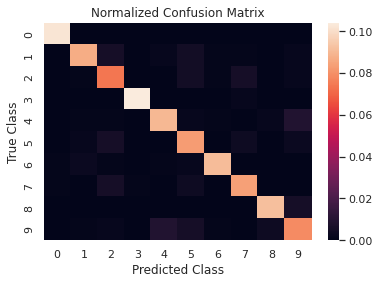

In [20]:
##Task1-Question3.e

# Plot the normalized confusion matrix
sns.set_theme()

c = sklearn.metrics.confusion_matrix(test_label, y_pred, normalize='all')
#print(c)
ax = sns.heatmap(c)
ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')

In [21]:
print('Confusion Matrix',c)

Confusion Matrix [[0.102 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.087 0.006 0.    0.002 0.005 0.001 0.001 0.    0.002]
 [0.    0.001 0.074 0.    0.    0.005 0.001 0.006 0.    0.002]
 [0.    0.    0.    0.104 0.    0.    0.    0.002 0.    0.   ]
 [0.    0.001 0.001 0.    0.09  0.002 0.001 0.    0.002 0.009]
 [0.    0.002 0.006 0.    0.    0.083 0.    0.004 0.    0.003]
 [0.001 0.003 0.001 0.    0.001 0.002 0.091 0.    0.    0.   ]
 [0.001 0.    0.006 0.001 0.    0.004 0.    0.084 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.092 0.006]
 [0.    0.001 0.002 0.    0.009 0.006 0.001 0.    0.004 0.079]]


In [22]:
##Task1-Question3.f

# Precision, Recall, and F-1 score on the test set

precision_obj = tf.keras.metrics.Precision()
precision_obj.update_state(test_label_o, y_pred_o)
precision = precision_obj.result().numpy()


recall_obj = tf.keras.metrics.Recall()
recall_obj.update_state(test_label_o, y_pred_o)
recall = recall_obj.result().numpy()


f1_score = 2*(precision*recall)/(recall+precision)

print('Precision: ',precision)
print('Recall: ',recall)
print('F1_score: ',f1_score)

Precision:  0.89137053
Recall:  0.878
F1_score:  0.8846347623684223


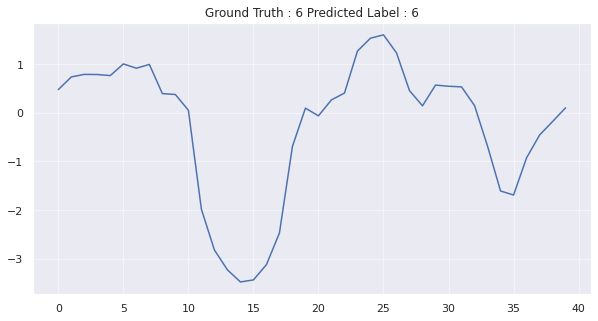

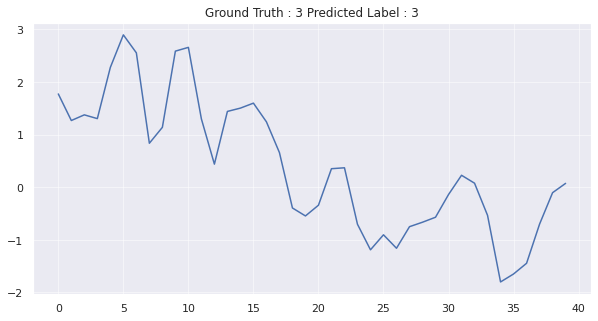

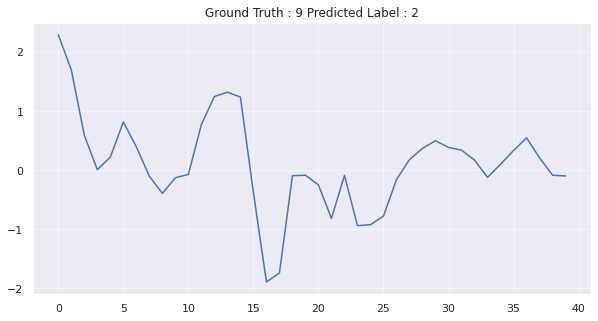

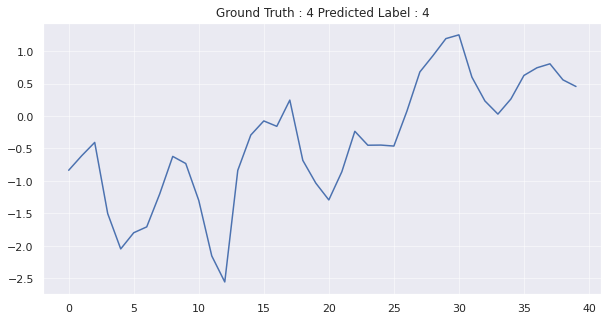

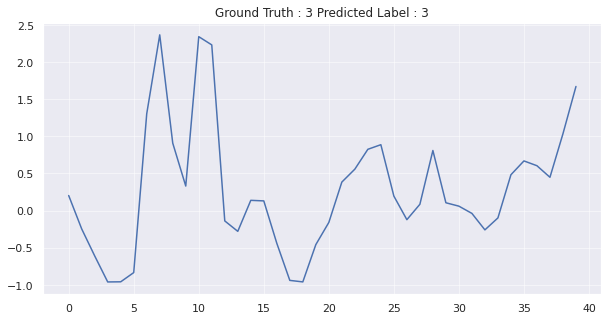

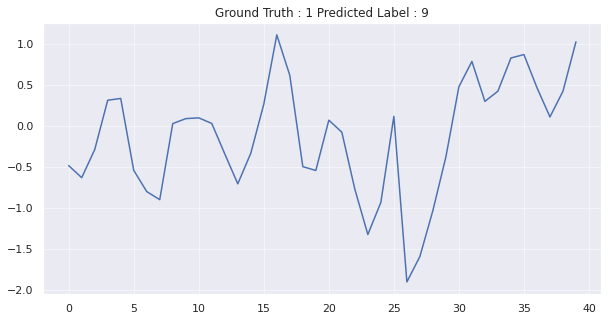

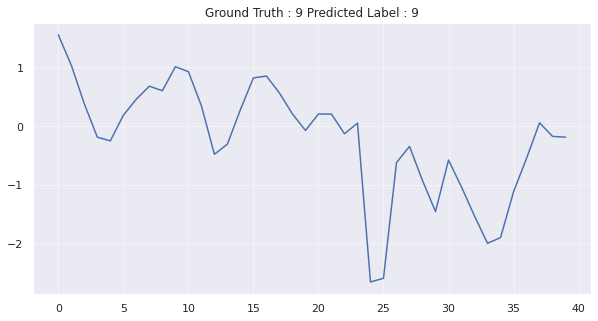

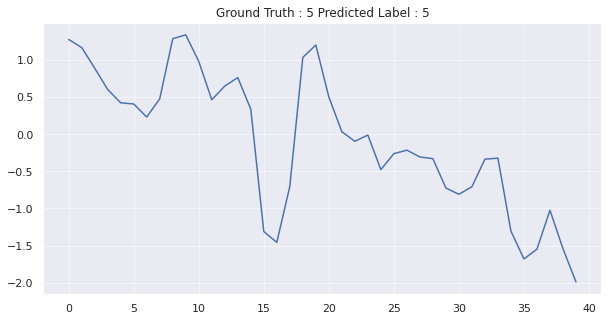

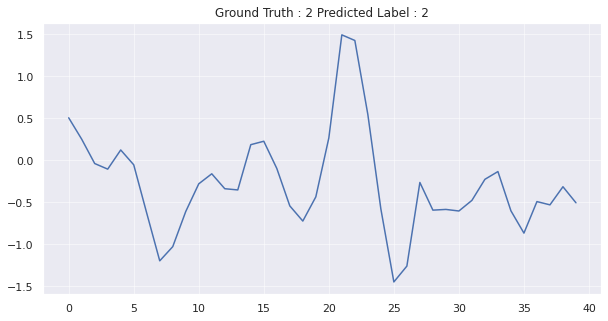

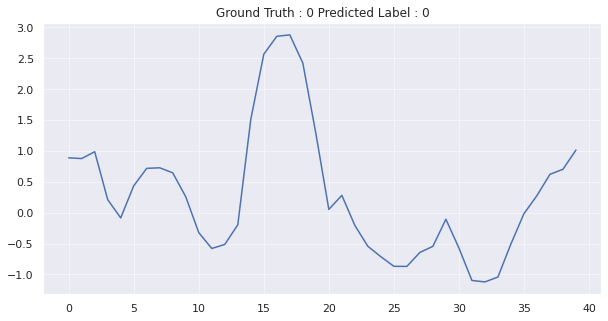

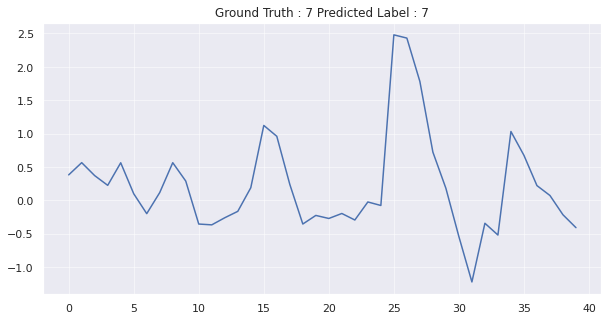

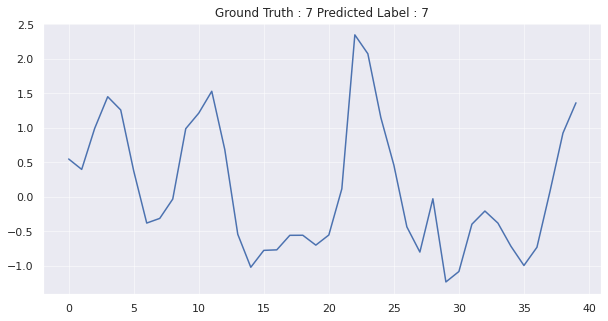

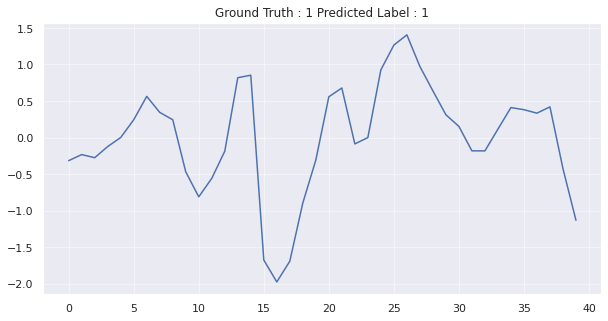

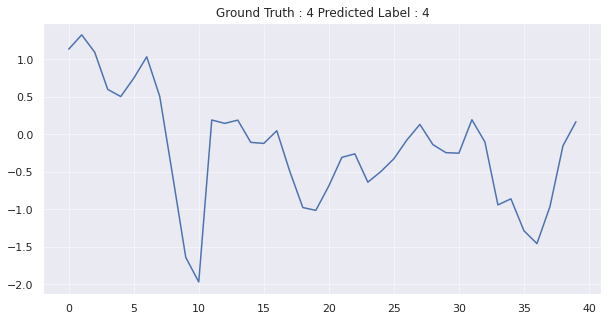

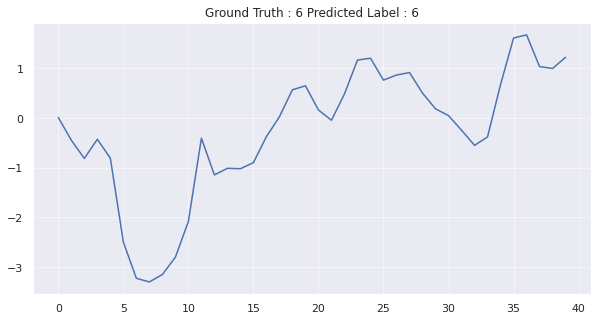

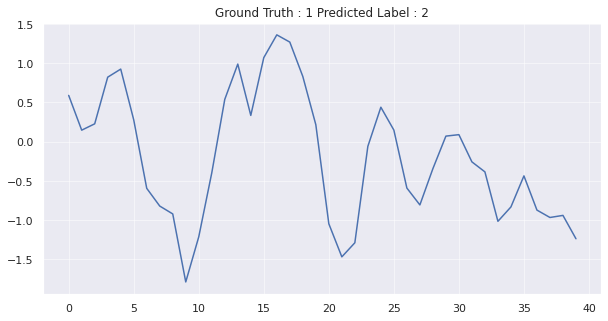

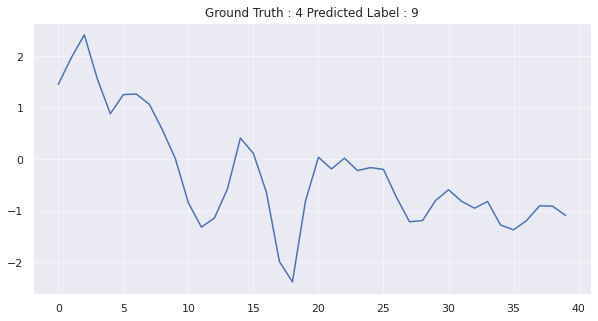

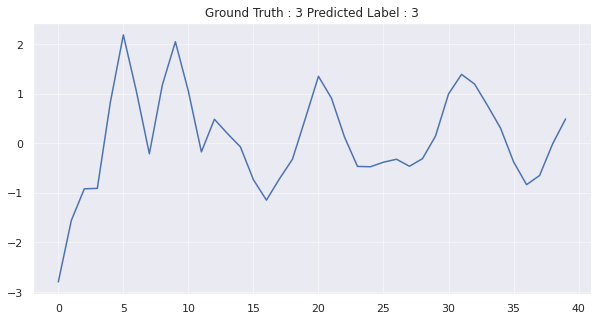

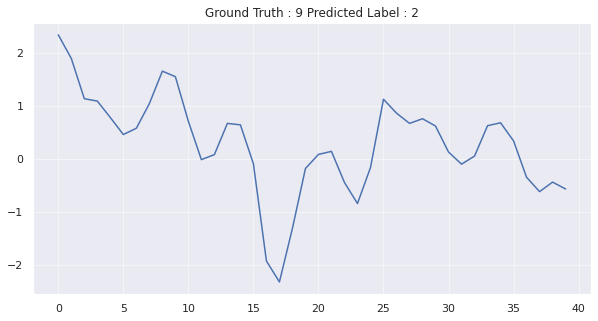

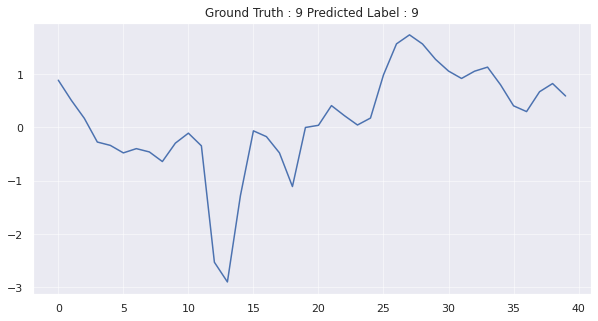

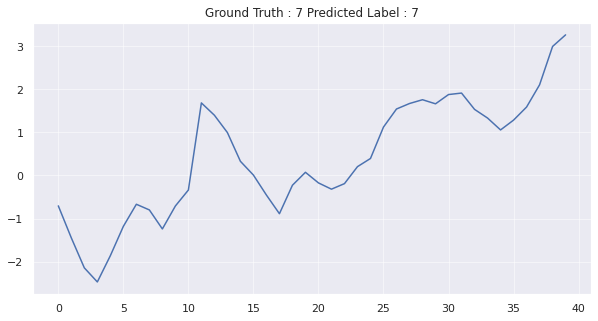

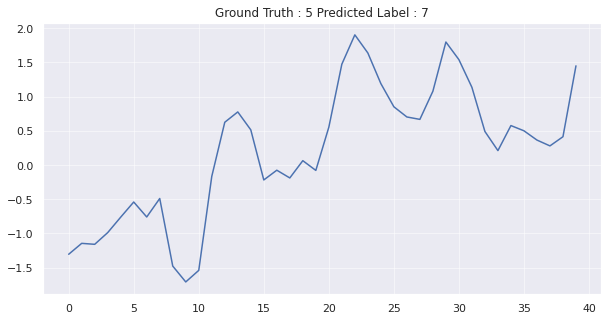

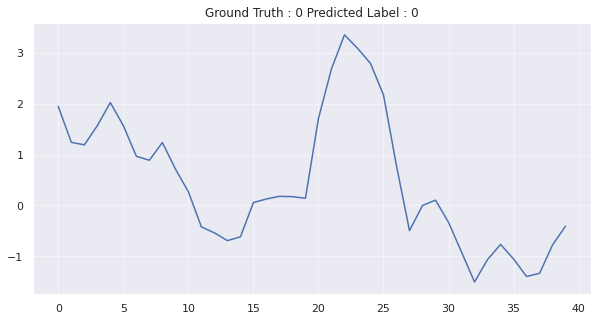

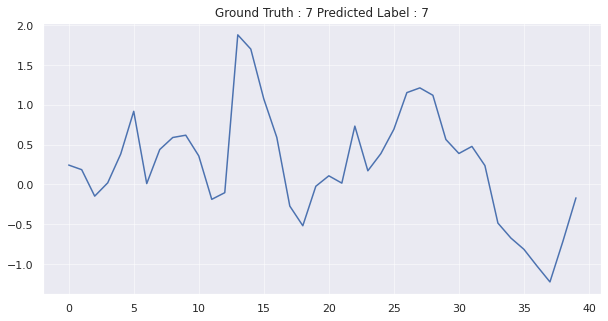

In [25]:
##Task1-Question4
# Experimentation Section 

%matplotlib inline
a, b = 50, 2
for i in range(1, 25):
    fig = plt.figure(figsize=(10,5))
    plt.title('Ground Truth : '+str(test_label[i])+' Predicted Label : '+str(y_pred[i]))
    
    plt.plot(range(40), test_data[i])  
    plt.grid(alpha=0.5)
    plt.show()

## Preparing Images for Explanation Methods

In [42]:
index = np.random.randint(1000)
test_image = test_data_reshaped[index]

print('test_image shape ', test_image.shape)

test_image_reshaped = np.expand_dims(test_image, axis=0)
print('test_image_reshaped ', test_image_reshaped.shape)

test_image shape  (40, 1)
test_image_reshaped  (1, 40, 1)


In [43]:
np.random.seed(222)
inp_im = test_data[index]
label = test_label[index]
preds = model.predict(test_image_reshaped)
print('prediction : ', np.argmax(preds))
print('gt : ', test_label[index])

prediction :  5
gt :  9


In [44]:
#Creating 3D input image
inp_im_temp1 = inp_im[:, np.newaxis]
inp_im_temp2 =  np.repeat(inp_im_temp1, 3, axis=1)
inp = np.expand_dims(inp_im_temp2, axis=1)
print(inp.shape)

(40, 1, 3)


In [45]:
inp_model = np.expand_dims(inp[:,:,0], axis=0)
print(inp_model.shape)

(1, 40, 1)


##Grad Cam Explanation

In [30]:
def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    #print (cam)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    grad_cam_heatmap = cam / cam.max()
    return grad_cam_heatmap

In [31]:
%%time
grad_cam_output = grad_cam(model, test_image_reshaped, 'conv1d_2')
grad_cam_resized  = np.expand_dims(grad_cam_output, axis=1)

CPU times: user 223 ms, sys: 3.15 ms, total: 226 ms
Wall time: 227 ms


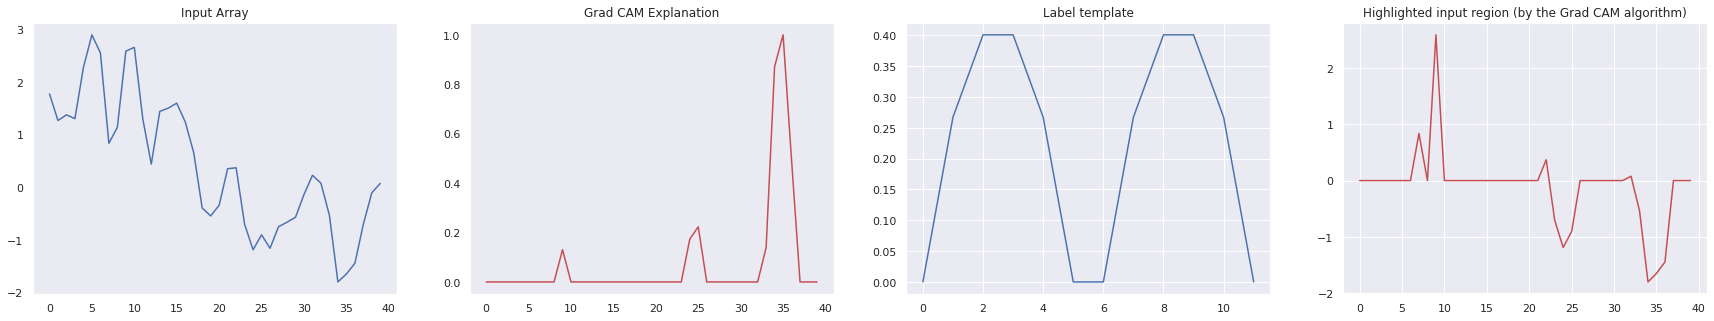

In [32]:
threshold = np.sort(grad_cam_output)[-12]

plt.figure(figsize=(30, 5))

plt.subplot(141)
plt.title('Input Array')
plt.grid()
plt.plot(inp_im)

plt.subplot(142)
plt.plot(grad_cam_resized, 'r')
plt.grid()
plt.title('Grad CAM Explanation')

plt.subplot(143)
plt.plot(data['templates']['x'][label])
plt.title('Label template')

plt.subplot(144)
plt.plot(inp_im*(grad_cam_output>threshold),'r')
plt.title('Highlighted input region (by the Grad CAM algorithm)')

plt.show()

Text(0.5, 1.0, 'original and Grad CAM explanation superimposed')

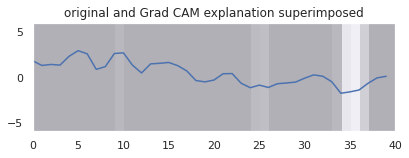

In [33]:
#Experimental Section
plt.figure(figsize=(20, 2))
plt.plot(inp_im)
ax=plt.gca()
ax.imshow(np.expand_dims(grad_cam_output,axis=0),extent=[0,40,-6,6],cmap='gray',alpha=0.25)
plt.grid()
plt.title('original and Grad CAM explanation superimposed')

## LIME Explanation (LOCAL INTERPRETABLE
MODEL-AGNOSTIC EXPLANATION)


In [34]:
def lime(inp,model,num_perturb=150,kernel_width=0.25,num_top_features=6):
    superpixels = skimage.segmentation.quickshift(inp, kernel_size=2, max_dist=5, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    #print(perturbations[0]) #Show example of perturbation
    
    def perturb_image(img,perturbation,segments):
      active_pixels = np.where(perturbation == 1)[0]
      mask = np.zeros(segments.shape)
      for active in active_pixels:
          mask[segments == active] = 1 
      perturbed_image = copy.deepcopy(img)
      perturbed_image = perturbed_image*mask[:,:,np.newaxis]
      perturbed_image_squeeze = np.squeeze(perturbed_image, axis=1)
      pert = perturbed_image_squeeze[:, 0]
      return perturbed_image, pert

    #prediction array for perturbed image    
    predictions = []
    for pert in perturbations:
      perturbed_img = perturb_image(inp,pert,superpixels)[1]
      pred = model.predict(perturbed_img[np.newaxis,:])
      predictions.append(pred)
    
    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    # cosine distance computation 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
  
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    inp_model = np.expand_dims(inp[:,:,0], axis=0)
    preds = model.predict(inp_model)
    class_to_explain = np.argmax(preds)
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
   
    top_features = np.argsort(coeff)[-num_top_features:] 
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    
    exp = perturb_image(inp.astype('uint8'),mask,superpixels)[0]
    return exp

In [35]:
%%time
explanation_lime = lime(inp,model)

CPU times: user 7.53 s, sys: 332 ms, total: 7.86 s
Wall time: 7.73 s


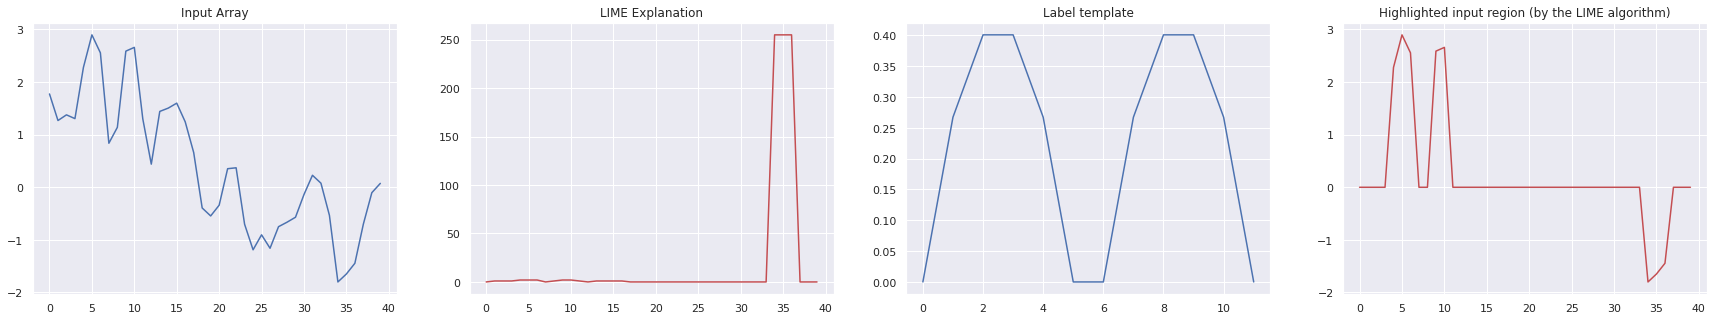

In [36]:
threshold = np.sort(explanation_lime[:,0,0])[-12]

plt.figure(figsize=(30, 5))

plt.subplot(141)
plt.title('Input Array')
plt.plot(inp_im)

plt.subplot(142)
plt.plot(explanation_lime[:,:,0], 'r')
plt.title('LIME Explanation')

plt.subplot(143)
plt.plot(data['templates']['x'][label])
plt.title('Label template')

plt.subplot(144)
plt.plot(inp_im*(explanation_lime[:,0,0]>threshold), 'r')
plt.title('Highlighted input region (by the LIME algorithm)')

plt.show()

Text(0.5, 1.0, 'original and LIME explanation superimposed')

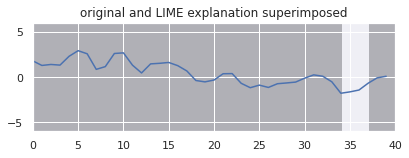

In [37]:
#Experimental Section
plt.figure(figsize=(20, 2))
plt.plot(inp_im)
ax=plt.gca()
ax.imshow(np.expand_dims(explanation_lime[:,0,0],axis=0),extent=[0,40,-6,6],cmap='gray',alpha=0.25)
plt.title('original and LIME explanation superimposed')



##Saliency Map using vanilla gradient

In [38]:
class SaliencyMap():
    def __init__(self, model):
        """Constructs a Vanilla Gradient Map by computing dy/dx.

        Args:
            model: The TensorFlow model used to evaluate Gradient Map.
                model takes image as input and outputs probabilities vector.
        """
        self.model = model


    def get_top_predicted_idx(self, image):
        """Outputs top predicted class for the input image.

        Args:
            img_processed: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Index of the top predicted class for the input image.
        """
        preds = self.model.predict(image)
        top_pred_idx = tf.argmax(preds[0])
        return top_pred_idx


    def get_gradients(self, image):
        """Computes the gradients of outputs w.r.t input image.

        Args:
            image: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        image = tf.convert_to_tensor(image)
        top_pred_idx = self.get_top_predicted_idx(image)

        with tf.GradientTape() as tape:
            tape.watch(image)
            preds = self.model(image)
            top_class = preds[:, top_pred_idx]

        grads = tape.gradient(top_class, image)
        return grads


    def norm_grad(self, grad_x):
        """Normalizes gradient to the range between 0 and 1
        (for visualization purposes).

        Args:
            grad_x: numpy gradients array.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        abs_grads = np.abs(grad_x)
        grad_max_ = np.max(abs_grads, axis=3)[0]
        arr_min, arr_max  = np.min(grad_max_), np.max(grad_max_)
        normalized_grad = (grad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
        normalized_grad = normalized_grad.reshape(1,grad_x.shape[1],grad_x.shape[2],1)

        return normalized_grad

In [39]:
%%time
S=SaliencyMap(model)
test_image_reshaped_4D = np.expand_dims(test_image_reshaped, axis=3)
gradients=S.get_gradients(test_image_reshaped_4D)
norm_gradient=S.norm_grad(gradients)
norm_gradient_squeezed = np.squeeze(norm_gradient,axis=3)
norm_gradient_squeezed_final = np.squeeze(norm_gradient_squeezed,axis=0)

CPU times: user 298 ms, sys: 4.52 ms, total: 303 ms
Wall time: 323 ms


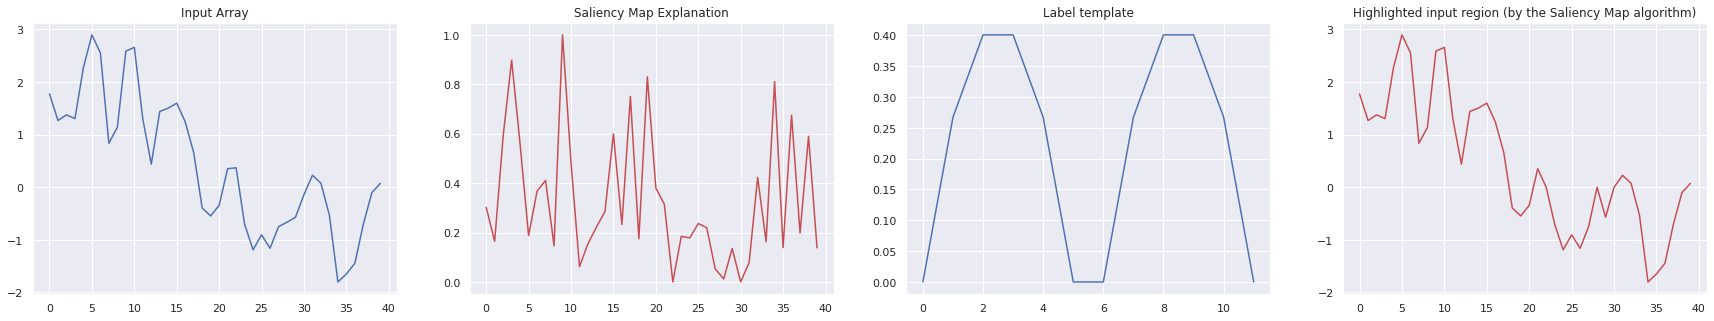

In [40]:
threshold = np.sort(norm_gradient_squeezed_final)[-12]

plt.figure(figsize=(30, 5))

plt.subplot(141)
plt.title('Input Array')
plt.plot(inp_im)

plt.subplot(142)
plt.plot(norm_gradient_squeezed_final, 'r')
plt.title('Saliency Map Explanation')


plt.subplot(143)
plt.plot(data['templates']['x'][label])
plt.title('Label template')


plt.subplot(144)
plt.plot(inp_im*(norm_gradient_squeezed_final[:,0]>threshold), 'r')
plt.title('Highlighted input region (by the Saliency Map algorithm)')

plt.show()

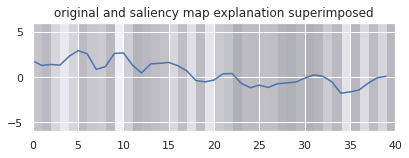

In [41]:
#Experimental Section
plt.figure(figsize=(20, 2))
ax=plt.gca()
plt.plot(inp_im)
ax.imshow(np.expand_dims(norm_gradient_squeezed_final[:,0],axis=0),extent=[0,40,-6,6],cmap='gray',alpha=0.25)
plt.title('original and saliency map explanation superimposed')
plt.show()

## Quantitative evaluation

In [46]:
def calculate_drop_increase(image, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    images = np.repeat(image[:, :, np.newaxis], 3, axis=3)
    predictions = model.predict(image)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    exmap1_thr_resized = exmap1_thr[:,:,:,0]
    ex_predictions = model.predict(exmap1_thr_resized)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [47]:
drop_rate_grad_cam = 0.
inc_rate_grad_cam = 0.
for index in range(1000):
    image_reshaped_for_analysis = np.expand_dims(np.expand_dims(test_data[index], axis=0), axis=-1)
    prediction=model(image_reshaped_for_analysis).numpy()    
    explanation_map = grad_cam(model,image_reshaped_for_analysis, 'conv1d_2')
    explanation_map_reshaped = np.repeat(np.expand_dims(np.expand_dims(explanation_map, axis=0), axis=-1)[:, :, np.newaxis], 3, axis=3)
    drop_increase = calculate_drop_increase(image_reshaped_for_analysis, model, explanation_map_reshaped, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate_grad_cam += drop_increase[0]
    if drop_increase[1]:
      inc_rate_grad_cam +=1

drop_rate_grad_cam /= 1000
inc_rate_grad_cam /= 1000

print('Average Drop% using grad cam: ',drop_rate_grad_cam*100)
print('Average Increase% using grad cam: ',inc_rate_grad_cam*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Average Drop% using grad cam:  47.31552578739324
Average Increase% using grad cam:  27.0


In [48]:
drop_rate_saliency_map = 0.
inc_rate_saliency_map = 0.

S=SaliencyMap(model)


for index in range(1000):
    image_reshaped_for_analysis = np.expand_dims(np.expand_dims(test_data[index], axis=0), axis=-1)
    prediction=model(image_reshaped_for_analysis).numpy()   
    gradients=S.get_gradients(np.expand_dims(image_reshaped_for_analysis, axis=3))
    norm_gradient=S.norm_grad(gradients)
    drop_increase = calculate_drop_increase(image_reshaped_for_analysis, model,norm_gradient, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate_saliency_map += drop_increase[0]
    if drop_increase[1]:
      inc_rate_saliency_map +=1

drop_rate_saliency_map /= 1000
inc_rate_saliency_map /= 1000

print('Average Drop% using saliency map: ',drop_rate_saliency_map*100)
print('Average Increase% using saliency map: ',inc_rate_saliency_map*100)

Average Drop% using saliency map:  46.027745618245746
Average Increase% using saliency map:  19.1


In [49]:
drop_rate_lime = 0.
inc_rate_lime = 0.

for index in range(1000):
    print('index: ',index)
    image_reshaped_for_analysis = np.expand_dims(np.expand_dims(test_data[index], axis=0), axis=-1)
    
    prediction=model(image_reshaped_for_analysis).numpy()    
    #explanation_map = lime(model,image_reshaped_for_analysis, 'dense')
    explanation_map = lime(np.expand_dims(np.repeat(test_data[index][:, np.newaxis], 3, axis=1), axis=1),model)
    explanation_map_reshaped = np.expand_dims(explanation_map, axis=0)
    drop_increase = calculate_drop_increase(image_reshaped_for_analysis, model, explanation_map_reshaped, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate_lime += drop_increase[0]
    if drop_increase[1]:
      inc_rate_lime +=1

drop_rate_lime /= 1000
inc_rate_lime /= 1000



index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index:  90
index:  9

In [50]:
print('Average Drop% using LIME: ',drop_rate_lime*100)
print('Average Increase% using LIME: ',inc_rate_lime*100)

Average Drop% using LIME:  22.9629418784696
Average Increase% using LIME:  33.5
